# Faster R-CNN on PASCAL VOC 2007

# 1. Environment Setup
## 1.0. Check gpu

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


## 1.1. Install matplotlib

In [2]:
!pip install matplotlib

## 1.2. Import

In [3]:
import augmentation, dataset, main, torch
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

## 1.3. Config

In [4]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
min_size, max_size = 600, 1000

RPN_config = {'anchor_scale' : (128, 256, 512), 'anchor_aspect_ratio' : (0.5, 1.0, 2.0), 'downsample' : 16, 
              'in_channels' : 512, 'num_anchors' : 9,
              'bbox_reg_weights' : (1., 1., 1., 1.),
              'iou_positive_thresh' : 0.7, 'iou_negative_high' : 0.3, 'iou_negative_low' : 0,
              'batch_size_per_image' : 256, 'positive_fraction' : 0.5, 
              'min_size' : 16, 'nms_thresh' : 0.7, 
              'top_n_train' : 2000, 'top_n_test' : 300}

FastRCNN_config = {'output_size' : 7, 'downsample' : 16, 
                   'out_channels' : 4096, 'num_classes' : 21,
                   'bbox_reg_weights' : (10., 10., 5., 5.),
                   'iou_positive_thresh' : 0.5, 'iou_negative_high' : 0.5, 'iou_negative_low' : 0.1,
                   'batch_size_per_image' : 128, 'positive_fraction' : 0.25, 
                   'min_size' : 1, 'nms_thresh' : 0.3, 
                   'score_thresh' : 0.05, 'top_n' : 50}

TRAIN_config = {'epochs' : 15,
                'lr' : 0.001, 'momentum' : 0.9, 'weight_decay' : 0.0005,
                'milestones' : [10], 'clip' : 10,
                'epoch_freq' : 1, 'print_freq' : 1,
                'save' : True, 'SAVE_PATH' : './'}

TEST_config = {'num_classes' : 21, 'iou_thresh' : 0.5, 'use_07_metric' : True}

DEMO_config = {'min_size' : min_size, 'mean' : imagenet_mean, 'std' : imagenet_std, 'score_thresh' : 0.7}

gpu_id = 0

# 2. Data Preprocessing

In [5]:
batch_size = 1

data_dir = '../Data/'

In [6]:
train_transform = augmentation.Compose([augmentation.Resize(min_size, max_size), 
                                        augmentation.Flip(), augmentation.ToTensor(), 
                                        augmentation.Normalize(mean=imagenet_mean, std=imagenet_std)])
test_transform = augmentation.Compose([augmentation.Resize(min_size, max_size), augmentation.ToTensor(), 
                                       augmentation.Normalize(mean=imagenet_mean, std=imagenet_std)])


train_dataset = dataset.VOC_Detection(root=data_dir, year='2007', image_set='trainval', 
                                      download=False, transforms=train_transform, use_diff=False)
test_dataset = dataset.VOC_Detection(root=data_dir, year='2007', image_set='test', 
                                     download=False, transforms=test_transform, use_diff=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

# 3. Train Model

In [7]:
FasterRCNN = main.FasterRCNN(RPN_config, FastRCNN_config, TRAIN_config, TEST_config, DEMO_config, gpu_id)

In [8]:
FasterRCNN.train(train_loader, test_loader)

Epoch 1 Started...
Epoch 1 mAP : 41.5610
Saved Best Model

Epoch 2 Started...
Epoch 2 mAP : 48.6243
Saved Best Model

Epoch 3 Started...
Epoch 3 mAP : 52.9132
Saved Best Model

Epoch 4 Started...
Epoch 4 mAP : 59.1059
Saved Best Model

Epoch 5 Started...
Epoch 5 mAP : 60.7533
Saved Best Model

Epoch 6 Started...
Epoch 6 mAP : 61.0014
Saved Best Model

Epoch 7 Started...
Epoch 7 mAP : 64.6341
Saved Best Model

Epoch 8 Started...
Epoch 8 mAP : 62.3078

Epoch 9 Started...
Epoch 9 mAP : 62.5933

Epoch 10 Started...
Epoch 10 mAP : 61.9710

Epoch 11 Started...
Epoch 11 mAP : 67.0413
Saved Best Model

Epoch 12 Started...
Epoch 12 mAP : 67.3774
Saved Best Model

Epoch 13 Started...
Epoch 13 mAP : 67.5454
Saved Best Model

Epoch 14 Started...
Epoch 14 mAP : 67.4671

Epoch 15 Started...
Epoch 15 mAP : 67.1578



Text(0, 0.5, 'RPN Train Loss')

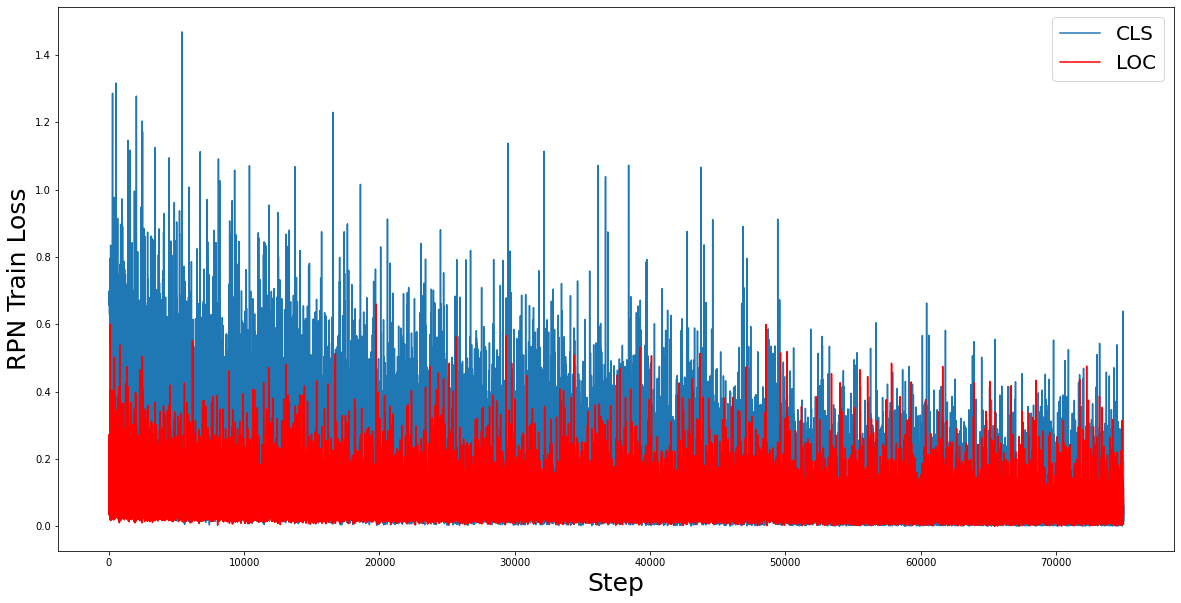

In [9]:
plt.figure(figsize=(20, 10))
plt.rcParams['axes.titlesize'] = 30

label_fontsize = 25

cls_lossline, = plt.plot(FasterRCNN.rpn_cls_losses, label='CLS')
loc_lossline, = plt.plot(FasterRCNN.rpn_loc_losses, color='red', label='LOC')
plt.legend(handles=[cls_lossline, loc_lossline], fontsize=20)
plt.xlabel('Step', fontsize=label_fontsize)
plt.ylabel('RPN Train Loss', fontsize=label_fontsize)

Text(0, 0.5, 'Fast R-CNN Train Loss')

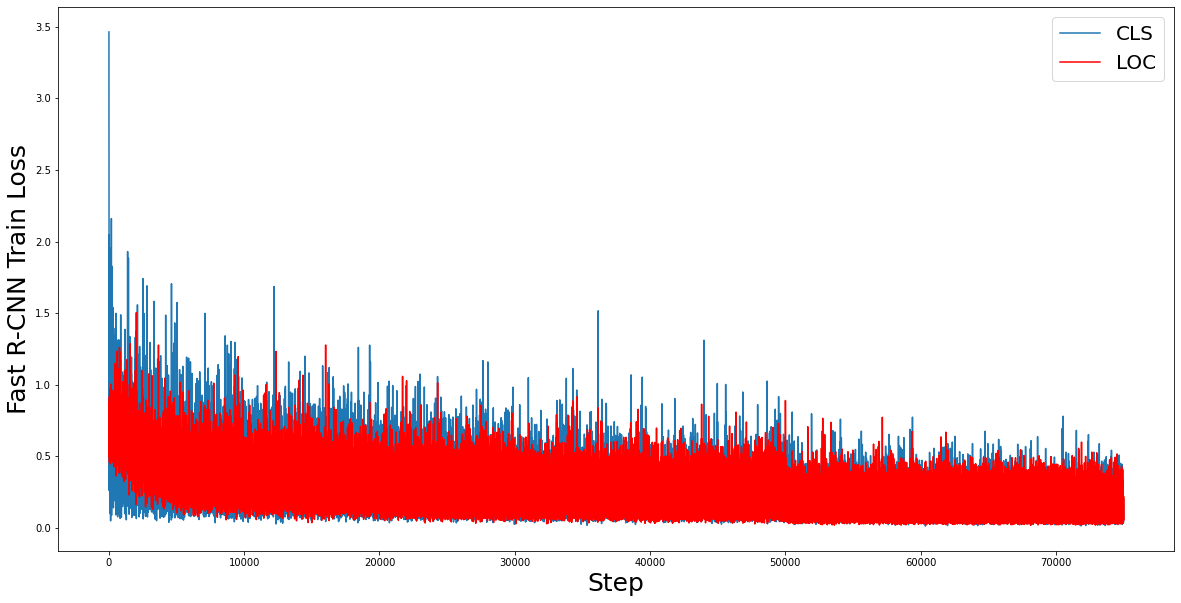

In [10]:
plt.figure(figsize=(20, 10))
plt.rcParams['axes.titlesize'] = 30

label_fontsize = 25

cls_lossline, = plt.plot(FasterRCNN.roi_cls_losses, label='CLS')
loc_lossline, = plt.plot(FasterRCNN.roi_loc_losses, color='red', label='LOC')
plt.legend(handles=[cls_lossline, loc_lossline], fontsize=20)
plt.xlabel('Step', fontsize=label_fontsize)
plt.ylabel('Fast R-CNN Train Loss', fontsize=label_fontsize)

# 4. Inference

In [11]:
FasterRCNN = main.FasterRCNN(RPN_config, FastRCNN_config, TRAIN_config, TEST_config, DEMO_config, gpu_id)
FasterRCNN.model.load_state_dict(torch.load('./epoch_013.pt'))

<All keys matched successfully>

In [12]:
VOC_LABELS = ('__background__', 
              'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 
              'horse','motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

demo_img = './sample.png'

img, pred_labels, pred_scores, pred_detections = FasterRCNN.demo(demo_img)

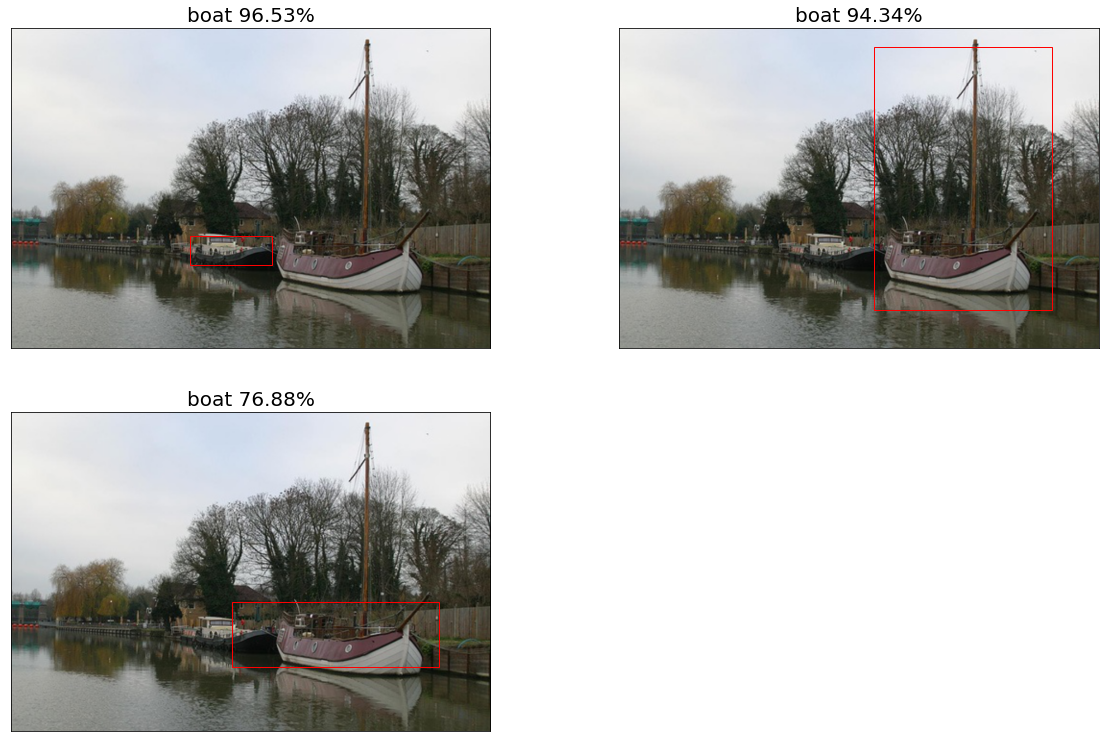

In [13]:
plt.figure(figsize=(20, 20))
plt.rcParams['axes.titlesize'] = 20
plt.axis('off')

for i in range(min(6, pred_labels.shape[0])):
    plt.subplot(3, 2, i+1)
    pred_label, pred_score, pred_detection = pred_labels[i], pred_scores[i], pred_detections[i]
    image = plt.imshow(img); image.axes.get_xaxis().set_visible(False); image.axes.get_yaxis().set_visible(False)
    
    plt.gca().set_title(VOC_LABELS[int(pred_label)] + ' ' + str(round(100 * pred_score, 2)) + '%')
    min_x, min_y, max_x, max_y = pred_detection
    plt.gca().add_patch(Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, edgecolor='r', facecolor='none'))